In [97]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [98]:
df = pd.read_csv('covid_ml.csv')

In [99]:
df = df.iloc[:,1:10]

In [100]:
dfcopy = df.copy()

In [101]:
dfcopy.dropna(inplace=True)

In [102]:
dfcopy.urgency_of_admission.value_counts(normalize=True)

Low     0.745238
High    0.254762
Name: urgency_of_admission, dtype: float64

In [103]:
#df.groupby('urgency_of_admission').describe()

# Use of groupby

In [104]:
yesnomapper = {'Yes':1, 'No':0}

In [105]:
for col in dfcopy.columns[2:-1]:
    dfcopy[col] = dfcopy[col].map(yesnomapper)
    print(f'Done with {col}')

Done with cough
Done with fever
Done with chills
Done with sore_throat
Done with headache
Done with fatigue


In [106]:
dfcopy['sex'] = dfcopy.sex.map({'female': 0, 'male': 1})

In [107]:
dfcopy['urgency_of_admission'] = dfcopy.urgency_of_admission.map({'Low':0, 'High':1})

## Training the Logistic regression

In [108]:
X = dfcopy.iloc[:,:-1]
y = dfcopy.iloc[:,-1]

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [110]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

In [111]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [112]:
y_pred = classifier.predict(X_test)

In [113]:
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_pred, y_test)


In [114]:
print(f'Accuracy for tt set for Logistic Regression = {(cm_test[0][0] + cm_test[1][1])/len(y_test)}')

Accuracy for tt set for Logistic Regression = 0.7321428571428571


In [115]:
y_pred_train = classifier.predict(X_train)

#### Direct implementation of Logistic regression does not giving satisfactory result because of class imbalance

## Adjusting class imbalance using SMOTE 

In [116]:
from imblearn.over_sampling import SMOTE

In [117]:
os = SMOTE(random_state= 0)

In [118]:
columns = X_train.columns

In [119]:
os_data_X, os_data_y = os.fit_sample(X_train, y_train)

In [120]:
os_data_X = pd.DataFrame(data = os_data_X, columns = columns)

In [121]:
os_data_y =pd.DataFrame(data = os_data_y, columns = ['urgency_of_admission'])

In [45]:
#converting columns to values to list

#y = os_data_y.columns.values.tolist()

In [122]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [123]:
logreg = LogisticRegression(C= 1000, max_iter= 1000)

In [124]:
logreg.fit(os_data_X, os_data_y.urgency_of_admission.ravel())

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [125]:
y_pred2 = logreg.predict(X_test)

In [126]:
cm_test = confusion_matrix(y_pred2, y_test)

In [127]:
print(f'Accuracy for test set for Logistic Regression = {(cm_test[0][0] + cm_test[1][1])/len(y_test)}')

Accuracy for test set for Logistic Regression = 0.5654761904761905


In [128]:
y_predt = logreg.predict(os_data_X)

In [129]:
cm_train = confusion_matrix(y_predt, os_data_y)

In [130]:
print(f'Accuracy for train set for Logistic Regression = {round((cm_train[0][0] + cm_train[1][1])/len(os_data_y),2)}')

Accuracy for train set for Logistic Regression = 0.62


In [131]:
cm_test = confusion_matrix(y_test, y_pred2)

In [132]:
cm_test

array([[68, 55],
       [18, 27]])

In [133]:
df_cm

,Predicted Low,Predicted High
Actual Low,68,55
Actual High,18,27


## Confusion Matrix

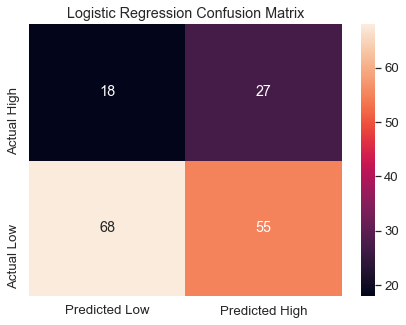

In [134]:
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots()
fig.set_size_inches(7,5)
df_cm = pd.DataFrame(cm_test, index = ['Actual Low','Actual High'],
                  columns = ['Predicted Low','Predicted High'])
sns.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, ax = ax)
ax.set_ylim([0,2]);
ax.set_title('Logistic Regression Confusion Matrix')
fig.savefig('Logistic_CM.png')

### Classification report

In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_pred2, y_test))

              precision    recall  f1-score   support

           0       0.55      0.79      0.65        86
           1       0.60      0.33      0.43        82

    accuracy                           0.57       168
   macro avg       0.58      0.56      0.54       168
weighted avg       0.58      0.57      0.54       168



## ROC curve

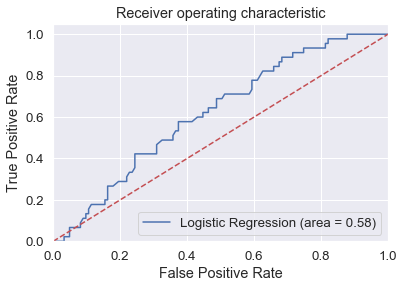

In [68]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Saving dataframe to csv to be used for deep model

In [203]:
data = pd.DataFrame(data = os_data_X, columns = os_data_X.columns)

In [206]:
data['urgency'] = os_data_y

In [209]:
data.to_csv('processed_over.csv')

In [212]:
testdata = pd.DataFrame(data = X_test, columns = X_test.columns)
testdata['urgency'] = y_test

In [216]:
testdata.to_csv('processed_over_test.csv')

In [69]:
from fastai.tabular import *

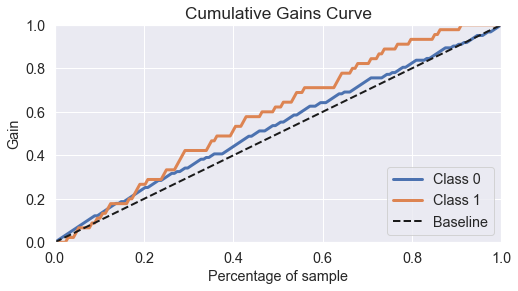

In [173]:
import scikitplot as skplt
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
skplt.metrics.plot_cumulative_gain(y_true = testdf.urgency, y_probas= logreg.predict_proba(testdf.iloc[:,:-1]), ax=ax)
#    plt.savefig('lift_curve.png')

,urgency_of_admission
0,0
1,0
2,0
3,0
4,0
...,...
1001,1
1002,1
1003,1
1004,1


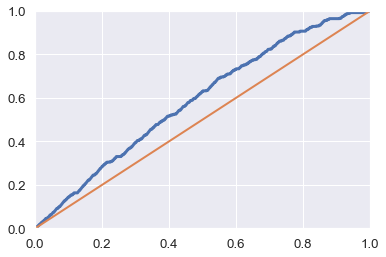

In [152]:
fig, ax = plt.subplots()
classes = np.unique(os_data_y)
percentages, gains = skplt.metrics.cumulative_gain_curve(os_data_y, logreg.predict_proba(os_data_X)[:,1])
ax.plot(percentages, gains, lw=3, label = f'Class {classes[0]}')
ax.set_xlim([0.0,1.0])
ax.set_ylim([0.0,1.0])
ax.plot([0,1],[0,1], lw =2, label = 'Baseline')

In [174]:
lg_predictions = logreg.predict_proba(testdf.iloc[:,:-1])

In [175]:
lg_predictions.size

336

In [193]:
testdf.sort_values(by= ['probability'], ascending = False, inplace = True )

In [196]:
lr_df = testdf[['probability', 'urgency']]

In [182]:
import pickle

In [194]:
pickle_out = open('lg_predictions.pkl', 'wb')

In [198]:
pickle.dump(lr_df, pickle_out)

In [199]:
pickle_out.close()

In [176]:
testdf = pd.read_csv('processed_over_test.csv')

In [177]:
testdf = testdf.iloc[:,1:]

In [178]:
len(testdf)

168

In [181]:
len(logreg.predict_proba(testdf.iloc[:,:-1]))

168